In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

PROJECT_DIR = Path.cwd().parent
DATA_DIR = PROJECT_DIR / "data"
IMG_DIR = PROJECT_DIR / "images"
IMG_DIR.mkdir(exist_ok=True)

train = pd.read_csv(DATA_DIR / "train_processed.csv", dtype={"StateHoliday":"string"}, low_memory=False)
test  = pd.read_csv(DATA_DIR / "test_processed.csv",  dtype={"StateHoliday":"string"}, low_memory=False)

train["Date"] = pd.to_datetime(train["Date"])
test["Date"]  = pd.to_datetime(test["Date"])



train.head()


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,CompetitionDistance_missing,CompetitionOpenSinceMonth_missing,CompetitionOpenSinceYear_missing,Promo2SinceWeek_missing,Promo2SinceYear_missing,PromoInterval_missing
0,1,5,2015-07-31,5263,555,1,1,0,1,c,...,0,0,0,NaN,0,0,0,1,1,1
1,2,5,2015-07-31,6064,625,1,1,0,1,a,...,1,13,2010,"Jan,Apr,Jul,Oct",0,0,0,0,0,0
2,3,5,2015-07-31,8314,821,1,1,0,1,a,...,1,14,2011,"Jan,Apr,Jul,Oct",0,0,0,0,0,0
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,...,0,0,0,NaN,0,0,0,1,1,1
4,5,5,2015-07-31,4822,559,1,1,0,1,a,...,0,0,0,NaN,0,0,0,1,1,1


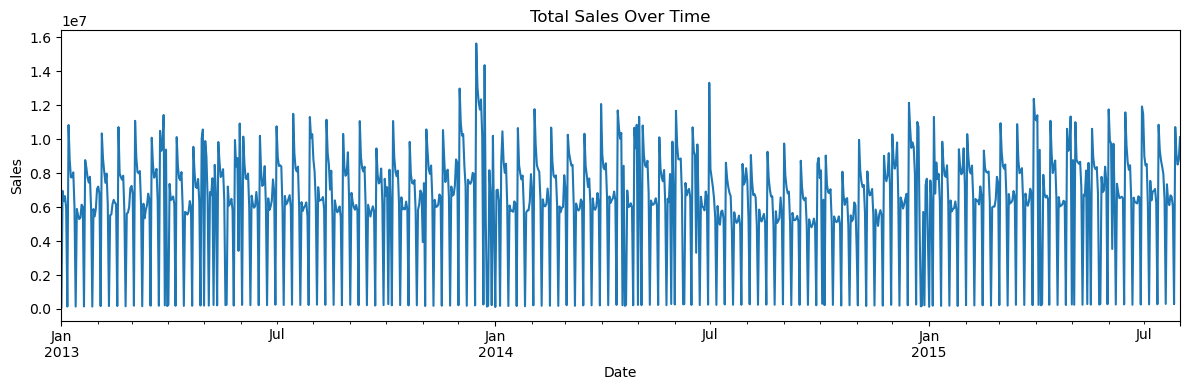

In [2]:
daily_sales = train.groupby("Date")["Sales"].sum()

plt.figure(figsize=(12,4))
daily_sales.plot()
plt.title("Total Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.tight_layout()

plt.savefig(IMG_DIR / "sales_trend_over_time.png", dpi=150)
plt.show()


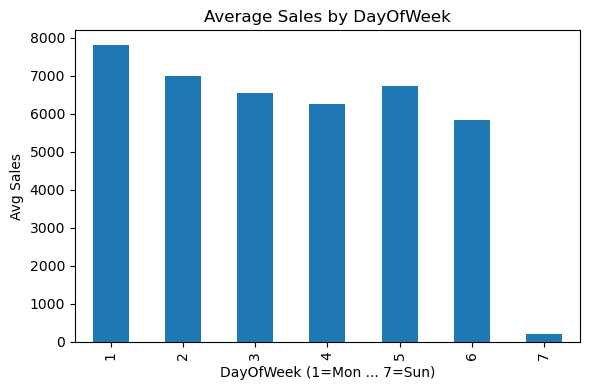

In [3]:
dow_sales = train.groupby("DayOfWeek")["Sales"].mean()

plt.figure(figsize=(6,4))
dow_sales.plot(kind="bar")
plt.title("Average Sales by DayOfWeek")
plt.xlabel("DayOfWeek (1=Mon ... 7=Sun)")
plt.ylabel("Avg Sales")
plt.tight_layout()
plt.savefig(IMG_DIR / "02_avg_sales_by_dayofweek.png", dpi=150)
plt.show()


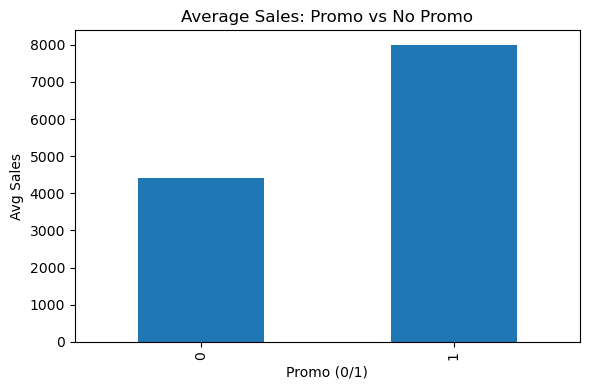

In [4]:
promo_sales = train.groupby("Promo")["Sales"].mean()

plt.figure(figsize=(6,4))
promo_sales.plot(kind="bar")
plt.title("Average Sales: Promo vs No Promo")
plt.xlabel("Promo (0/1)")
plt.ylabel("Avg Sales")
plt.tight_layout()
plt.savefig(IMG_DIR / "03_promo_vs_no_promo.png", dpi=150)
plt.show()


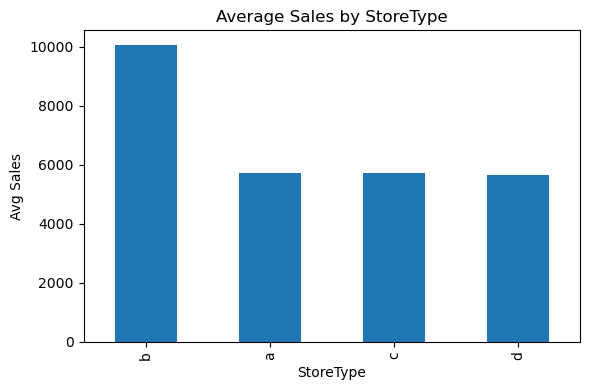

In [5]:
if "StoreType" in train.columns:
    st = train.groupby("StoreType")["Sales"].mean().sort_values(ascending=False)

    plt.figure(figsize=(6,4))
    st.plot(kind="bar")
    plt.title("Average Sales by StoreType")
    plt.xlabel("StoreType")
    plt.ylabel("Avg Sales")
    plt.tight_layout()
    plt.savefig(IMG_DIR / "04_avg_sales_by_storetype.png", dpi=150)
    plt.show()


In [6]:
# ตัวเลขสรุปเพื่อเอาไปเขียน Insight แบบมีหลักฐาน

promo_mean = train.groupby("Promo")["Sales"].mean()
promo0 = promo_mean.get(0, np.nan)
promo1 = promo_mean.get(1, np.nan)
uplift_pct = (promo1 - promo0) / promo0 * 100

dow_mean = train.groupby("DayOfWeek")["Sales"].mean()
best_dow = int(dow_mean.idxmax())
worst_dow = int(dow_mean.idxmin())

st_mean = train.groupby("StoreType")["Sales"].mean().sort_values(ascending=False)
best_st = st_mean.index[0]

print("Promo uplift %:", round(uplift_pct, 2))
print("Best DayOfWeek:", best_dow)
print("Worst DayOfWeek:", worst_dow)
print("Best StoreType:", best_st)


Promo uplift %: 81.37
Best DayOfWeek: 1
Worst DayOfWeek: 7
Best StoreType: b


## Insights (Business)

- ยอดขายรวมมีแนวโน้มขึ้นลงตามช่วงเวลา (Seasonality) จึงควรวางแผนสต๊อกและกำลังคนตามช่วงยอดพีค/ยอดตก  
- วันในสัปดาห์มียอดขายเฉลี่ยต่างกัน โดยวันที่ยอดขายเฉลี่ยสูงสุดคือ **DayOfWeek = 1** และต่ำสุดคือ **DayOfWeek = 7**  
- ช่วงที่มี Promo ยอดขายเฉลี่ยสูงกว่าไม่มี Promo ประมาณ **81.37%** แสดงว่าโปรโมชั่นช่วยกระตุ้นยอดขายได้ชัดเจน  
- StoreType ที่มียอดขายเฉลี่ยสูงสุดคือ **b** ควรโฟกัสกลยุทธ์/การจัดทรัพยากรกับกลุ่มสาขาประเภทนี้
